In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from graphing import graph_normal, show_results
from get_data import get_apple_stock_split

In [11]:
scaler_X_std = StandardScaler()
scaler_Y_std = StandardScaler()

scaler_X_min = MinMaxScaler()
scaler_Y_min = MinMaxScaler()

DAYS_LAG = 5

X_train, X_test, y_train, y_test = get_apple_stock_split(DAYS_LAG)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


X_train_scale_std = scaler_X_std.fit_transform(X_train)
y_train_scale_std = scaler_Y_std.fit_transform(y_train)

X_test_scale_std = scaler_X_std.transform(X_test)
y_test_scale_std = scaler_Y_std.transform(y_test)


X_train_scale_min = scaler_X_min.fit_transform(X_train)
y_train_scale_min = scaler_Y_min.fit_transform(y_train)

X_test_scale_min = scaler_X_min.transform(X_test)
y_test_scale_min = scaler_Y_min.transform(y_test)

[*********************100%***********************]  1 of 1 completed

Training samples: 2174, Testing samples: 544


In [21]:
def symlog(x):
    return np.sign(x) * np.log1p(np.abs(x))

y_log = symlog(y_test['Target'].values)

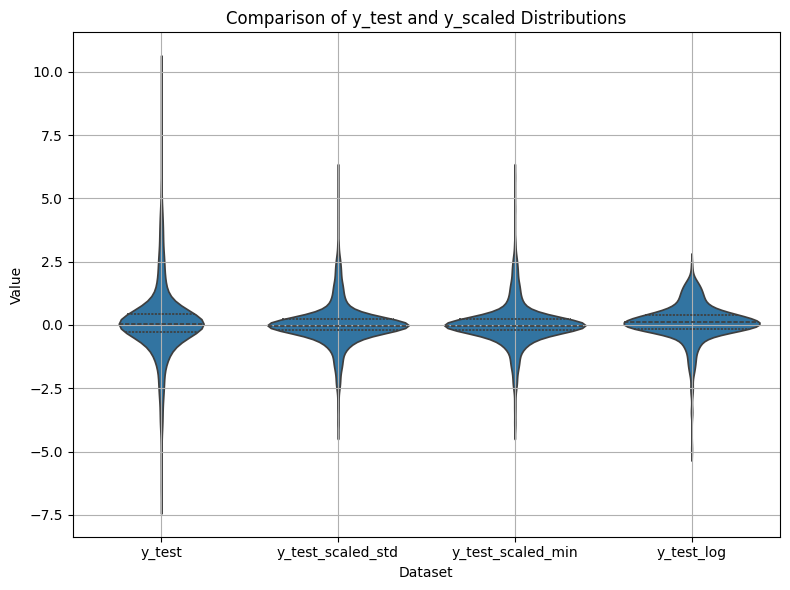

In [22]:
df_y = pd.DataFrame({
    'y_test': y_test['Target'].values,
    'y_test_scaled_std': y_test_scale_std.flatten(),
    'y_test_scaled_min': y_test_scale_std.flatten(),
    'y_test_log' : y_test_log
})
df_melted = df_y.melt(var_name='Dataset', value_name='Value')

# Plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Dataset', y='Value', data=df_melted, inner='quartile')
plt.title('Comparison of y_test and y_scaled Distributions')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(y_test_scale[:10])
print(y_test['Target'].values[:10])

In [6]:
data = yf.download("AAPL", start="2014-01-01", end="2023-01-01")
data['Target'] = -data['Close'].diff(-1)
data.head(5)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2014-01-02,17.215368,17.336750,17.180822,17.294734,234684800,-0.378155
2014-01-03,16.837214,17.233104,16.820095,17.206961,392467600,0.091814
2014-01-06,16.929028,17.018351,16.607521,16.727347,412610800,-0.121069
2014-01-07,16.807959,16.992209,16.741977,16.941167,317209200,0.106443
2014-01-08,16.914402,16.979760,16.765943,16.769676,258529600,-0.215998


In [5]:
data[data.isna().any(axis=1)]

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,


In [10]:
# File: get_data.py

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

#average true value - simple moving average of the true range
def addATR(data, period=14):
    """
    Compute the Average True Range (ATR) manually.
    """
    # Calculate True Range (TR)
    data['TR'] = np.maximum(data['High'] - data['Low'], 
                            np.maximum(abs(data['High'] - data['Close'].shift(1)), 
                                       abs(data['Low'] - data['Close'].shift(1))))
    
    data['ATR'] = data['TR'].rolling(window=period).mean()
    
    return data

def addRSI(data):
    #RSI = 100 - 100/(1 + RS)
    #RS = avg gain/ avg loss
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    return data

days_lag = 5
# Download Apple stock data
data = yf.download("AAPL", start="2014-01-01", end="2023-01-01")

# Calculate moving averages and relative price change
data[f'SMA_{days_lag}'] = data['Close'].rolling(window=days_lag).mean()
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# Set target as next difference in price
data['Target'] = -data['Close'].diff(-1)

# Create lag columns
lags = {f'lag_{i}': data['Close'].diff(i) for i in range(1, days_lag + 1)}
data = data.assign(**lags)

# add RSI
data = addRSI(data)

#add atr
data = addATR(data)

# Add day of the week as an integer (Monday=0, ..., Friday=4)
data['Day_of_Week'] = data.index.dayofweek

# Drop rows with missing values
data.dropna(inplace=True)

# Features
X = data[['SMA_10', 'SMA_50', f'SMA_{days_lag}', 'High', 'Close', 'Open','Volume', 'Low', 'RSI', 'ATR', 'Day_of_Week'] + [f'lag_{i}' for i in range(1, days_lag + 1)]]
# Target
Y = data[['Target']]

X.head(51)
    

[*********************100%***********************]  1 of 1 completed


Price,SMA_10,SMA_50,SMA_5,High,Close,Open,Volume,Low,RSI,ATR,Day_of_Week,lag_1,lag_2,lag_3,lag_4,lag_5
Ticker,,,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,
Date,,,,,,,,,,,,,,,,
2014-03-14,16.630258,16.610922,16.650326,16.622093,16.427973,16.556342,237199200,16.375058,47.026171,0.242629,4,-0.186602,-0.373199,-0.356915,-0.195049,-0.180023
2014-03-17,16.627064,16.596458,16.624152,16.593281,16.492151,16.522209,199544800,16.464285,55.242055,0.235271,0,0.064178,-0.122423,-0.309021,-0.292736,-0.130871
2014-03-18,16.627565,16.592474,16.594785,16.655899,16.638052,16.465848,209647200,16.443932,65.754984,0.229389,1,0.145901,0.210079,0.023478,-0.163120,-0.146835
2014-03-19,16.624121,16.586567,16.561286,16.789601,16.633678,16.664989,224756000,16.562917,55.216986,0.217111,2,-0.004374,0.141527,0.205706,0.019104,-0.167494
2014-03-20,16.617702,16.581479,16.549075,16.677819,16.553518,16.590777,208398400,16.511250,53.460762,0.205236,3,-0.080160,-0.084534,0.061367,0.125546,-0.061056
2014-03-21,16.625311,16.576872,16.600296,16.711633,16.684080,16.654649,374046400,16.479315,56.690509,0.204296,4,0.130562,0.050402,0.046028,0.191929,0.256107
2014-03-24,16.651205,16.580543,16.678258,16.922976,16.881960,16.857851,355700800,16.752649,59.688258,0.210446,0,0.197880,0.328442,0.248281,0.243908,0.389809
2014-03-25,16.679071,16.590075,16.763358,17.087347,17.063551,16.954281,282293200,16.894477,63.815558,0.212548,1,0.181591,0.379471,0.510033,0.429873,0.425499
